    Month  Monthly Distribution Cumulative Distribution
0       1         108000.000000               108000.00
1       2         106161.702128               214161.70
2       3         104323.404255               318485.11
3       4         102485.106383               420970.21
4       5         100646.808511               521617.02
5       6          98808.510638               620425.53
6       7          96970.212766               717395.74
7       8          95131.914894               812527.66
8       9          93293.617021               905821.28
9      10          91455.319149               997276.60
10     11          89617.021277              1086893.62
11     12          87778.723404              1174672.34
12     13          85940.425532              1260612.77
13     14          84102.127660              1344714.89
14     15          82263.829787              1426978.72
15     16          80425.531915              1507404.26
16     17          78587.234043              158

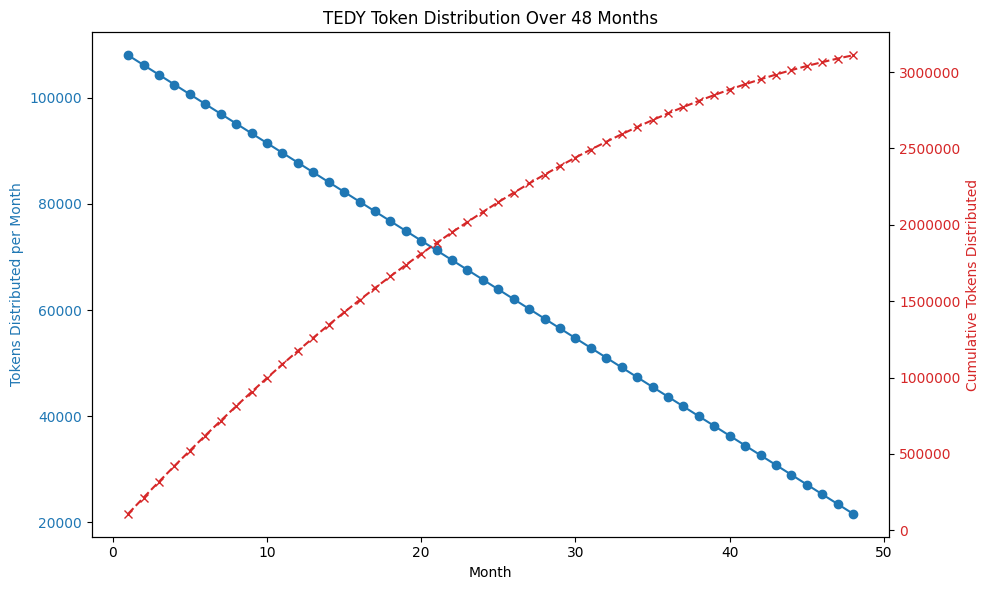

In [15]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
from matplotlib.ticker import FuncFormatter

def plain_format(x, pos):
    return '{:.0f}'.format(x)
    
# Constants 
start_reward = 108000
end_reward = 21600
total_months = 48

# Calculate rewards
months = np.arange(1, total_months + 1)
monthly_decrease = (start_reward - end_reward) / (total_months - 1)
monthly_rewards = np.maximum(start_reward - (monthly_decrease * (months - 1)), 0)
cumulative_rewards = np.cumsum(monthly_rewards)

# Create dataframe
data = {'Month': months,
        'Monthly Distribution': monthly_rewards,
        'Cumulative Distribution': cumulative_rewards}
df = pd.DataFrame(data)

# Convert scientific format to plain format for cumulative distribution
formatter = FuncFormatter(lambda x, _: '{:.0f}'.format(x))
ax2.yaxis.set_major_formatter(formatter)

# Plot with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_title('TEDY Token Distribution Over 48 Months')
ax1.set_xlabel('Month')
ax1.set_ylabel('Tokens Distributed per Month', color=color)
ax1.plot(months, monthly_rewards, label='Monthly Distribution', color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)

# Secondary axis (Cumulative Distribution)
ax2 = ax1.twinx() 
color = 'tab:red'
ax2.set_ylabel('Cumulative Tokens Distributed', color=color)
ax2.plot(months, cumulative_rewards, label='Cumulative Distribution', color=color, linestyle='--', marker='x')
ax2.tick_params(axis='y', labelcolor=color)

# Apply plain number formatting to both y-axes
ax1.yaxis.set_major_formatter(FuncFormatter(plain_format))
ax2.yaxis.set_major_formatter(FuncFormatter(plain_format))

fig.tight_layout()

df['Cumulative Distribution'] = df['Cumulative Distribution'].apply(lambda x: '{:.2f}'.format(x))
# Display dataframe
print(df)

plt.show()

In [17]:
import requests
import pandas as pd
import numpy as np

# Constants
price_tedy_in_ada = 1.56  # Current price of TEDY in ADA
user_lp_tokens = 862  # User's LP tokens
pool_id = "1c0ad45d50bd0a8c9bb851a9c59c3cb3e1ab2e2a29bd4d61b0e967ca.TEDY_ADA_POOL_IDENTITY"
# API Endpoints
pools_url = "https://analytics.teddyswap.org/v1/front/pools?after=0"
overview_url = "https://analytics.teddyswap.org/v1/pools/overview?after=0"

# Function to calculate monthly reward for a given month
def monthly_reward(month, start_reward, end_reward, total_months):
    monthly_decrease = (start_reward - end_reward) / (total_months - 1)
    return start_reward - (monthly_decrease * (month - 1))
    
# Fetch data from both API endpoints
pools_response = requests.get(pools_url)
overview_response = requests.get(overview_url)

# Check if API calls were successful
if pools_response.ok and overview_response.ok:
    pools_data = pools_response.json()
    overview_data = overview_response.json()

    # Extract the pool data from the pools endpoint
    pool_data = next((pool for pool in pools_data if pool['id'] == pool_id), None)
    
    # Extract the TVL from the overview endpoint
    pool_overview = next((pool for pool in overview_data if pool['id'] == pool_id), None)

    # Ensure both data points are not None
    if pool_data and pool_overview:
        # Extract values from the data
        total_lp_tokens = float(pool_data['lockedLQ']['amount'])
        pool_tvl_ada = pool_overview['tvl']

        # Calculate the average monthly reward for the first 12 months
        start_reward = 108000  # Starting monthly reward for the pool
        end_reward = 21600  # Ending monthly reward
        total_months = 48  # Total months in the reward program
        average_month_reward_12 = np.mean([monthly_reward(i, start_reward, end_reward, total_months) for i in range(1, 13)])

        # Annualized reward for the entire pool in TEDY
        pool_annual_rewards_tedy = average_month_reward_12 * 12 * 0.60  # 60% of the rewards go to the ADA/TEDY pool

        # Convert the pool's annual rewards from TEDY to ADA
        pool_annual_rewards_ada = pool_annual_rewards_tedy * price_tedy_in_ada

        # Calculate the pool's APR
        pool_apr = (pool_annual_rewards_ada / pool_tvl_ada) * 100

        # Annualized reward for the user in TEDY
        user_annual_rewards_tedy = average_month_reward_12 * 12 * (user_lp_tokens / total_lp_tokens) * 0.60

        # Convert the user's annual rewards from TEDY to ADA
        user_annual_rewards_ada = user_annual_rewards_tedy * price_tedy_in_ada

        # User's stake in ADA (assuming it's proportional to the TVL)
        user_stake_value_ada = pool_tvl_ada * (user_lp_tokens / total_lp_tokens)

        # Calculate the user's APR
        user_apr = (user_annual_rewards_ada / user_stake_value_ada) * 100

        # Create a DataFrame for the table including Pool Annual Rewards in ADA
        data = {
            'Statistic': [
                'User LP Tokens', 'User Stake in ADA', 'User Annual Rewards in ADA', 
                'User Share in Pool (%)', 'User APR (%)', 'Pool APR (%)', 
                'Pool TVL in ADA', 'Pool Annual Rewards in ADA'
            ],
            'Value': [
                user_lp_tokens, f"{user_stake_value_ada:.2f} ADA", f"{user_annual_rewards_ada:.2f} ADA", 
                f"{(user_lp_tokens / total_lp_tokens) * 100:.2f}%", f"{user_apr:.2f}%", f"{pool_apr:.2f}%",
                f"{pool_tvl_ada:.2f} ADA", f"{pool_annual_rewards_ada:.2f} ADA"
            ]
        }

        df = pd.DataFrame(data)
        display(df)
    else:
        print("Required pool data not found in the API response.")
else:
    print("Failed to retrieve data from the APIs")

# If the 'display' function is not


,Statistic,Value
0,User LP Tokens,862
1,User Stake in ADA,933.64 ADA
2,User Annual Rewards in ADA,1452.11 ADA
3,User Share in Pool (%),0.13%
4,User APR (%),155.53%
5,Pool APR (%),155.53%
6,Pool TVL in ADA,706923.70 ADA
7,Pool Annual Rewards in ADA,1099493.31 ADA
